In [1]:
!pip install geneticalgorithm


     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 44.3/44.3 kB 1.8 MB/s eta 0:00:00
  Preparing metadata (setup.py) ... done
  Created wheel for func-timeout: filename=func_timeout-4.3.5-py3-none-any.whl size=15080 sha256=92e04392502abed2694aee2d49817536dff6c255bcb22bdeaa44e73a9af93ddc
  Stored in directory: /root/.cache/pip/wheels/3f/83/19/b5552bb9630e353f7c5b15be44bf10900afe1abbbfcf536afd
Successfully built func-timeout


Results for KNN:
Accuracy: 0.96
Precision: 0.95
Recall: 0.99
Results for ANN:
Accuracy: 0.98
Precision: 0.97
Recall: 1.00
Number of Features Selected: 13
Indices of Selected Features: [ 1  7  8 11 13 14 18 19 20 21 22 23 27]
Classification Report for KNN:
               precision    recall  f1-score   support

           0       0.97      0.91      0.94        43
           1       0.95      0.99      0.97        71

    accuracy                           0.96       114
   macro avg       0.96      0.95      0.95       114
weighted avg       0.96      0.96      0.96       114

Confusion Matrix for KNN:
 [[39  4]
 [ 1 70]]
Classification Report for ANN:
               precision    recall  f1-score   support

           0       1.00      0.95      0.98        43
           1       0.97      1.00      0.99        71

    accuracy                           0.98       114
   macro avg       0.99      0.98      0.98       114
weighted avg       0.98      0.98      0.98       114

Confusion M

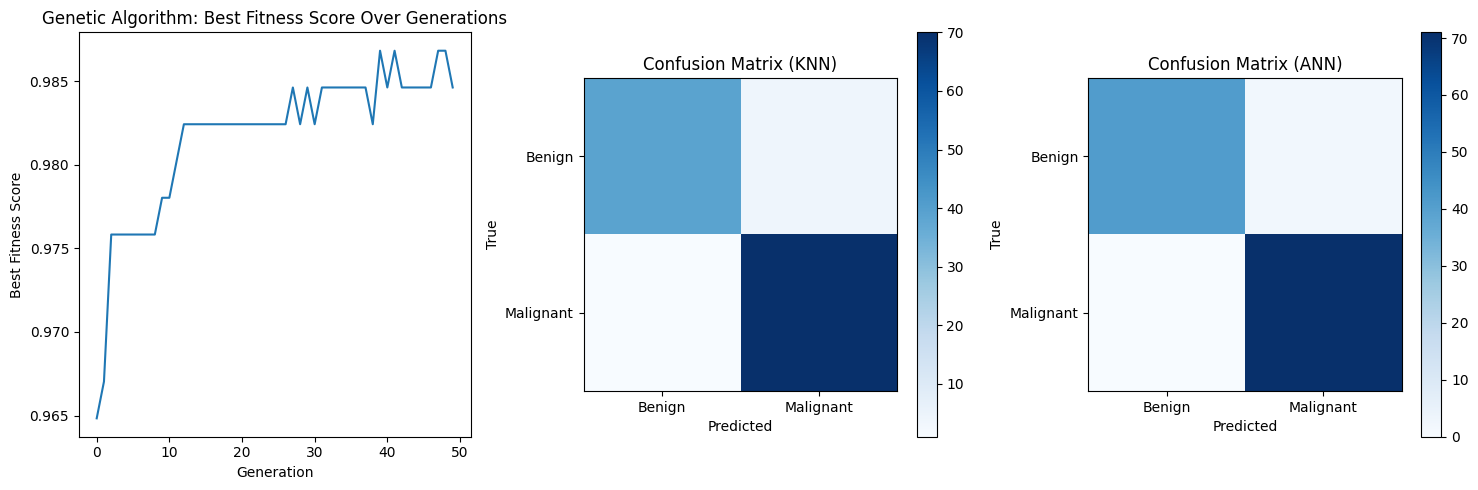

In [2]:
# Importing necessary libraries
import numpy as np
import pandas as pd
from sklearn.datasets import load_breast_cancer
from sklearn.model_selection import train_test_split
from sklearn.neighbors import KNeighborsClassifier
from sklearn.neural_network import MLPClassifier
import matplotlib.pyplot as plt
from sklearn.feature_selection import SelectKBest, f_classif
from sklearn.decomposition import PCA
from sklearn.pipeline import make_pipeline
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import confusion_matrix, accuracy_score, precision_score, recall_score
from sklearn.model_selection import cross_val_score
from sklearn.metrics import classification_report



# Load the Breast Cancer Wisconsin (Diagnostic) Data Set
data = load_breast_cancer()
X = data.data
y = data.target


# Split the data into training and testing sets
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# Standardize the features
scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train)
X_test_scaled = scaler.transform(X_test)

# Genetic Algorithm for feature selection
class GeneticAlgorithm:
    def __init__(self, population_size, generations, num_features, fitness_func):
        self.population_size = population_size
        self.generations = generations
        self.num_features = num_features
        self.fitness_func = fitness_func
        self.population = np.random.choice([0, 1], size=(population_size, num_features))

    def calculate_fitness(self, chromosome):
        return self.fitness_func(chromosome)

    def select_parents(self, fitness_scores):
        return self.population[np.argsort(fitness_scores)][-2:]

    def crossover(self, parents):
        crossover_point = np.random.randint(1, self.num_features - 1)
        child1 = np.concatenate((parents[0, :crossover_point], parents[1, crossover_point:]))
        child2 = np.concatenate((parents[1, :crossover_point], parents[0, crossover_point:]))
        return child1, child2

    def mutate(self, chromosome):
        mutation_point = np.random.randint(self.num_features)
        chromosome[mutation_point] = 1 - chromosome[mutation_point]
        return chromosome

    def evolve(self):
        best_fitness_history = []

        for generation in range(self.generations):
            fitness_scores = [self.calculate_fitness(chromosome) for chromosome in self.population]
            best_fitness = max(fitness_scores)
            best_fitness_history.append(best_fitness)

            parents = self.select_parents(fitness_scores)
            new_population = []

            for _ in range(self.population_size // 2):
                child1, child2 = self.crossover(parents)
                new_population.append(self.mutate(child1))
                new_population.append(self.mutate(child2))

            self.population = np.array(new_population)

        best_chromosome = self.population[np.argmax(fitness_scores)]
        return best_chromosome, best_fitness_history

# Fitness function for feature selection
def fitness_function(chromosome):
    selected_features = X_train_scaled[:, chromosome == 1]
    clf = make_pipeline(StandardScaler(), KNeighborsClassifier(n_neighbors=5))
    scores = cross_val_score(clf, selected_features, y_train, cv=5)
    return np.mean(scores)

# Initialize and run the Genetic Algorithm
ga = GeneticAlgorithm(population_size=20, generations=50, num_features=X_train_scaled.shape[1], fitness_func=fitness_function)
best_chromosome, best_fitness_history = ga.evolve()

# Select the best features based on the best chromosome
selected_features = X_train_scaled[:, best_chromosome == 1]
selected_test_features = X_test_scaled[:, best_chromosome == 1]

# Classification using K-Nearest Neighbors (KNN)
knn_classifier = KNeighborsClassifier(n_neighbors=5)
knn_classifier.fit(selected_features, y_train)
y_pred = knn_classifier.predict(selected_test_features)

# Classification using Artificial Neural Network (ANN)
ann_classifier = MLPClassifier(hidden_layer_sizes=(100, 50), max_iter=1000, random_state=42)
ann_classifier.fit(selected_features, y_train)
y_pred_ann = ann_classifier.predict(selected_test_features)

# Calculate and print accuracy, precision, and recall for KNN
accuracy = accuracy_score(y_test, y_pred)
precision = precision_score(y_test, y_pred)
recall = recall_score(y_test, y_pred)
print("Results for KNN:")
print(f"Accuracy: {accuracy:.2f}")
print(f"Precision: {precision:.2f}")
print(f"Recall: {recall:.2f}")

# Calculate and print accuracy, precision, and recall for ANN
accuracy_ann = accuracy_score(y_test, y_pred_ann)
precision_ann = precision_score(y_test, y_pred_ann)
recall_ann = recall_score(y_test, y_pred_ann)
print("Results for ANN:")
print(f"Accuracy: {accuracy_ann:.2f}")
print(f"Precision: {precision_ann:.2f}")
print(f"Recall: {recall_ann:.2f}")


# Print number of features and indices of selected features
num_selected_features = np.sum(best_chromosome)
selected_feature_indices = np.where(best_chromosome == 1)[0]
print(f"Number of Features Selected: {num_selected_features}")
print(f"Indices of Selected Features: {selected_feature_indices}")

# Print classification report and confusion matrix for KNN
print("Classification Report for KNN:\n", classification_report(y_test, y_pred))
print("Confusion Matrix for KNN:\n", confusion_matrix(y_test, y_pred))

# Print classification report and confusion matrix for ANN
print("Classification Report for ANN:\n", classification_report(y_test, y_pred_ann))
print("Confusion Matrix for ANN:\n", confusion_matrix(y_test, y_pred_ann))

# Plot confusion matrices and the history of best fitness scores
plt.figure(figsize=(15, 5))

plt.subplot(1, 3, 1)
plt.plot(best_fitness_history)
plt.title("Genetic Algorithm: Best Fitness Score Over Generations")
plt.xlabel("Generation")
plt.ylabel("Best Fitness Score")

plt.subplot(1, 3, 2)
plt.imshow(confusion_matrix(y_test, y_pred), interpolation='nearest', cmap=plt.cm.Blues)
plt.title("Confusion Matrix (KNN)")
plt.colorbar()
tick_marks = np.arange(2)
plt.xticks(tick_marks, ['Benign', 'Malignant'])
plt.yticks(tick_marks, ['Benign', 'Malignant'])
plt.xlabel('Predicted')
plt.ylabel('True')

plt.subplot(1, 3, 3)
plt.imshow(confusion_matrix(y_test, y_pred_ann), interpolation='nearest', cmap=plt.cm.Blues)
plt.title("Confusion Matrix (ANN)")
plt.colorbar()
tick_marks = np.arange(2)
plt.xticks(tick_marks, ['Benign', 'Malignant'])
plt.yticks(tick_marks, ['Benign', 'Malignant'])
plt.xlabel('Predicted')
plt.ylabel('True')

plt.tight_layout()
plt.show()

